In [1]:
# Launch 4 parallel processes and load module in all
addprocs(4)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Dec 14, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere y(ρ) = real(expect(ρ, q("y")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
Ω  = 2*π;        # Rabi frequency, unit period
τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
Γ = 1/(2*τ);     # Measurement dephasing rate
T = (0.0, 3*τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
H = (Ω/2)*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    hold(true)
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        hold(true)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
DMz = sqrt(Γ/2)*q("z");
DMy = sqrt(Γ/2)*q("y");

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, DMz)
    ymeas && (inc = lind(Δt, H, DMz, DMy))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt))
end;

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.060473465 s, Steps per second: 14866.024296772148
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.032294678 s, Steps per second: 27837.40404533527


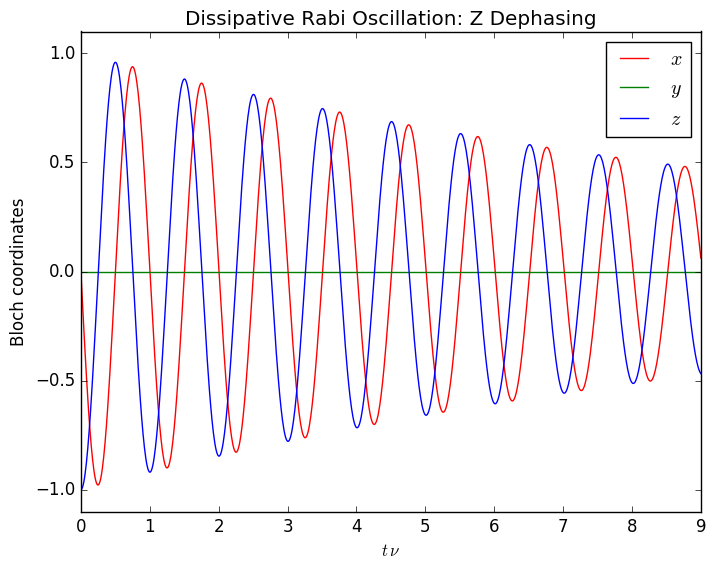

  0.046736 seconds (155.49 k allocations: 11.424 MB, 11.49% gc time)


In [6]:
sol = ensemble_average() # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.044449946 s, Steps per second: 20224.996448814585


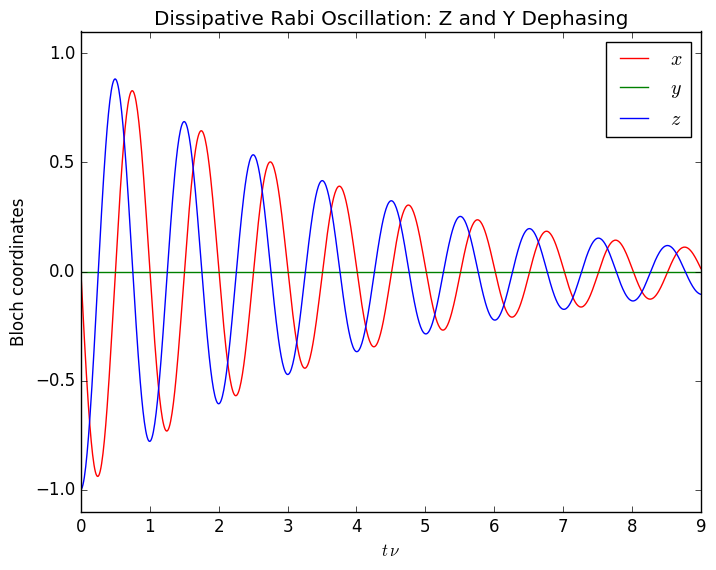

  0.040373 seconds (208.58 k allocations: 15.257 MB)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.038869011 s, Steps per second: 23128.965128544176


In [7]:
sol = ensemble_average(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{4}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{4}}\left[\sigma_z\,e^{-i\phi}\,\rho + \rho\,\sigma_z^\dagger\,e^{i\phi} - \langle\sigma_z\,e^{-i\phi} + \sigma_z^\dagger\,e^{i\phi}\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{4}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{4}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [8]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, ϕ=0.0)
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η)])
    ymeas && (inc = meas(Δt, H, [(exp(-im*ϕ).*q("z"), τ/η, η), (exp(-im*ϕ).*q("y"), τ/η, η)]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=true, readout=true)
    end
end;

### Single Trajectory Examples

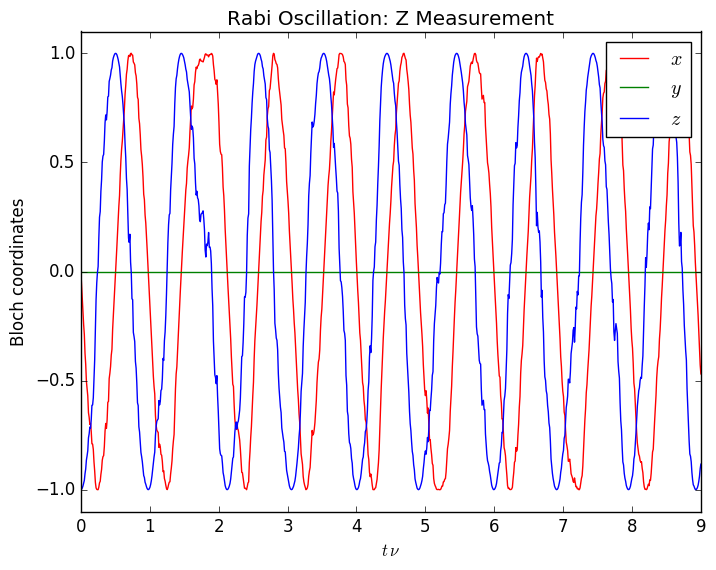

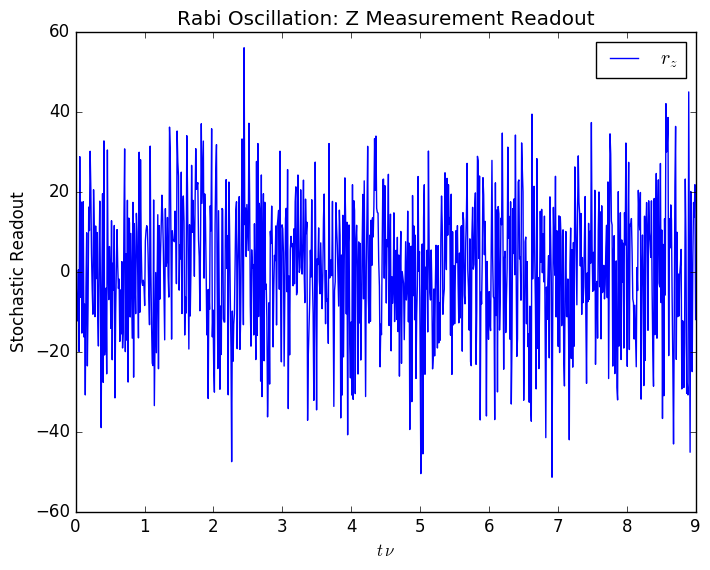

  0.032271 seconds (193.84 k allocations: 14.298 MB)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.058397954 s, Steps per second: 15394.374946766115
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.031749118 s, Steps per second: 28315.747228001735


In [9]:
sol = ensemble_realization() # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.06064951 s, Steps per second: 14822.873259816939
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.059682461 s, Steps per second: 15063.051773283947


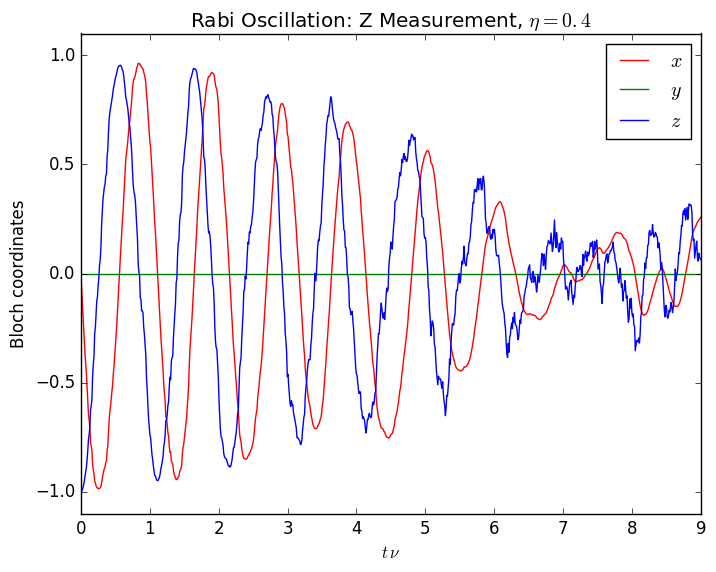

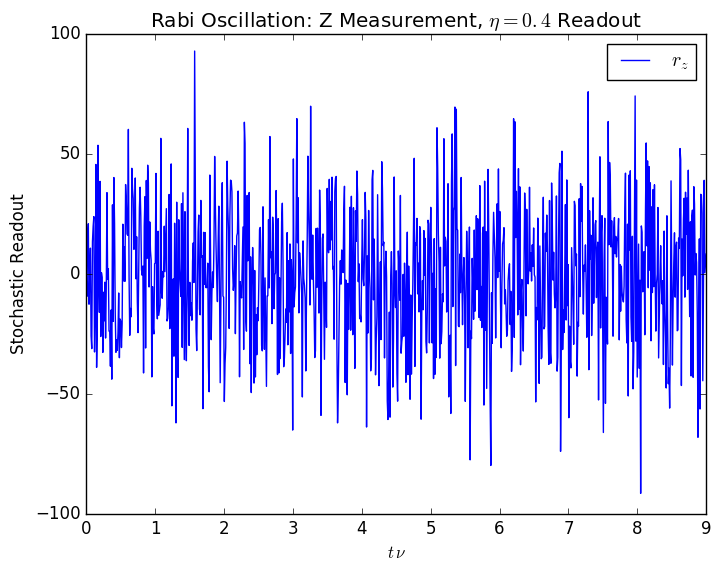

  0.060360 seconds (269.54 k allocations: 20.259 MB, 7.43% gc time)


In [10]:
sol = ensemble_realization(η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

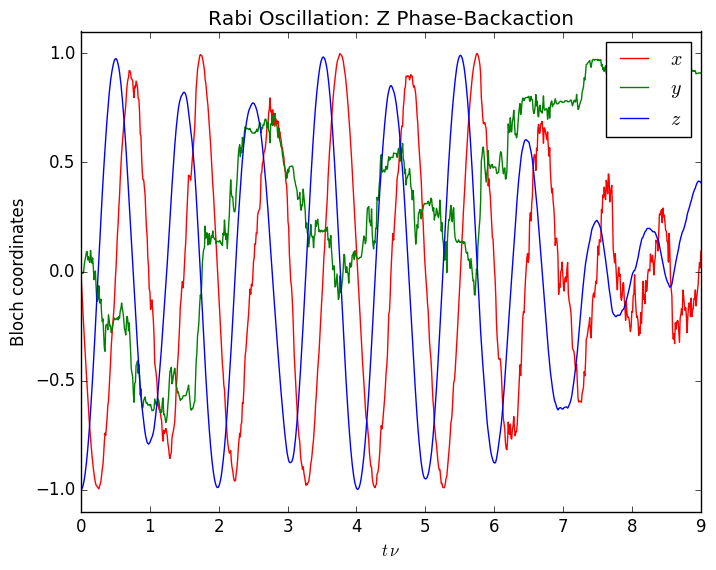

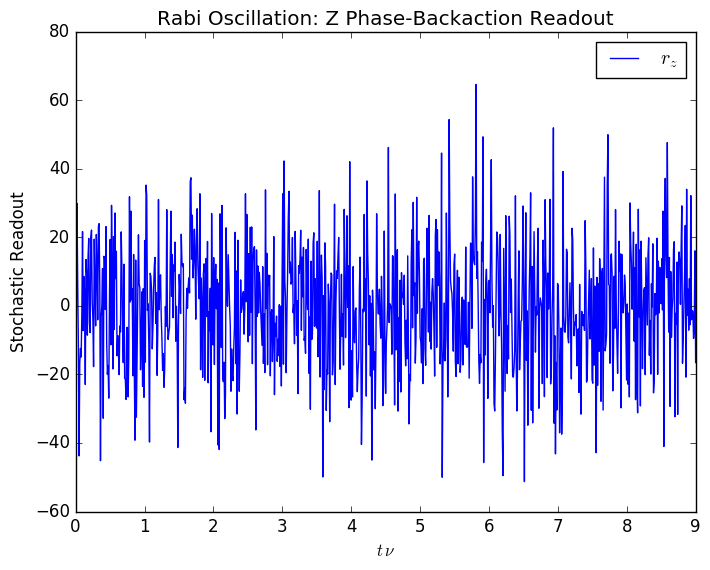

  0.038007 seconds (206.29 k allocations: 14.175 MB, 10.82% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.034235491 s, Steps per second: 26259.29915829161
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.037484688 s, Steps per second: 23983.126123392034


In [11]:
sol = ensemble_realization(ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.062841874 s, Steps per second: 14305.747788488929
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.058436477 s, Steps per second: 15384.226533711128


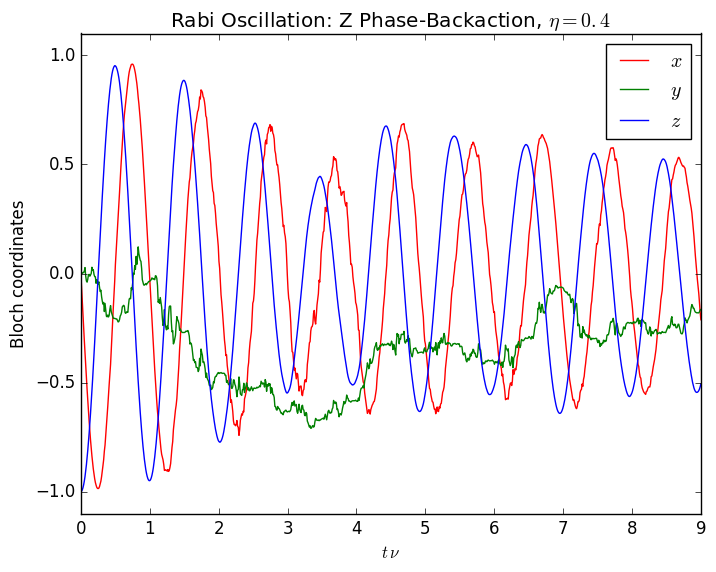

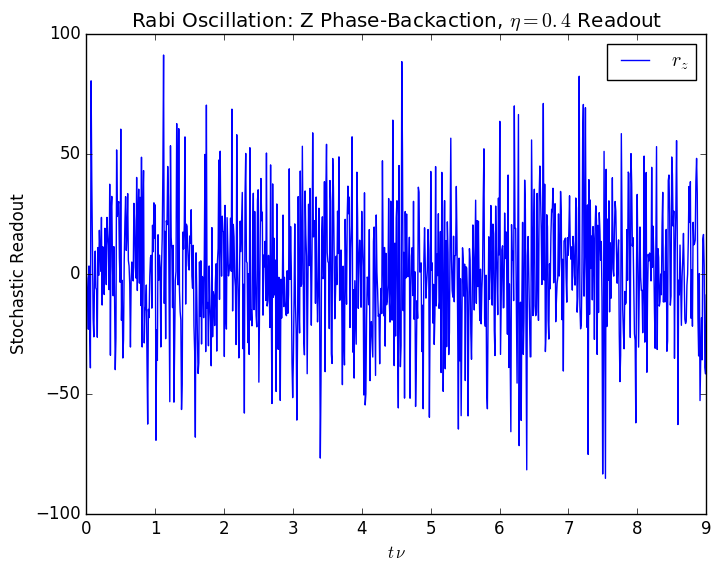

  0.059068 seconds (280.39 k allocations: 19.973 MB, 6.60% gc time)


In [12]:
sol = ensemble_realization(ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


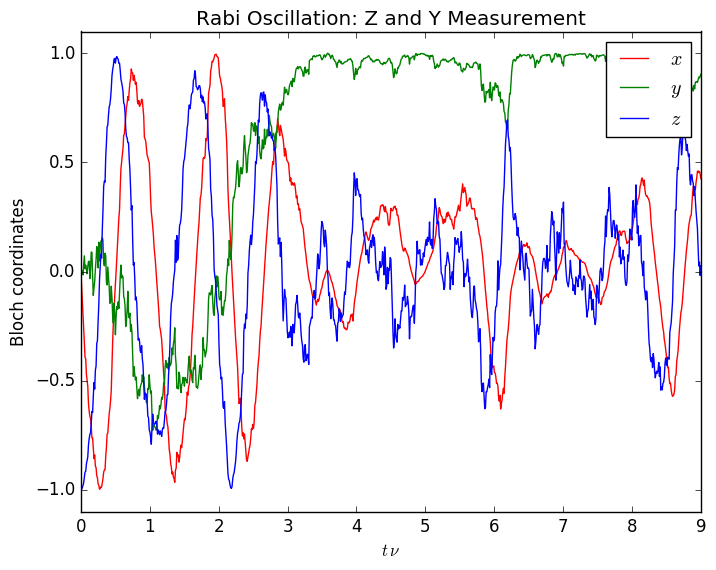

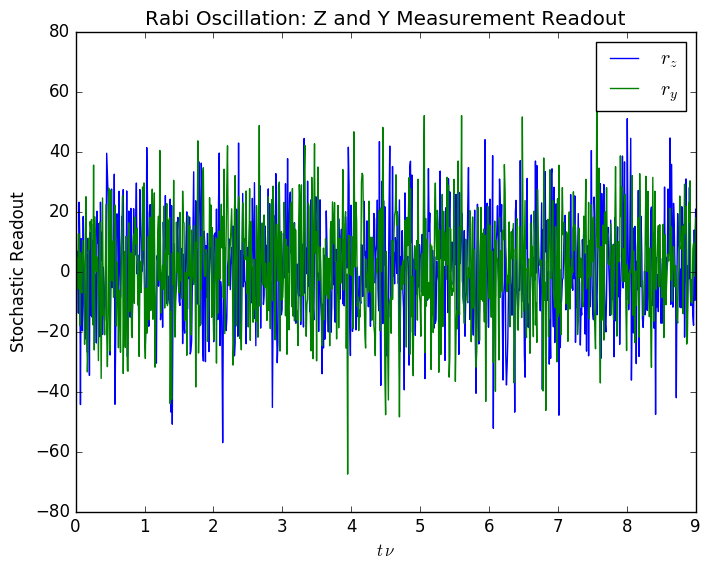

  0.050053 seconds (286.40 k allocations: 22.366 MB, 7.66% gc time)


INFO: Time elapsed: 0.065686673 s, Steps per second: 13686.18562855208
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.049271462 s, Steps per second: 18245.85598860452


In [13]:
sol = ensemble_realization(ymeas=true) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.094374711 s, Steps per second: 9525.856985140861
INFO: Trajectory: steps = 899, points = 899, values = 3


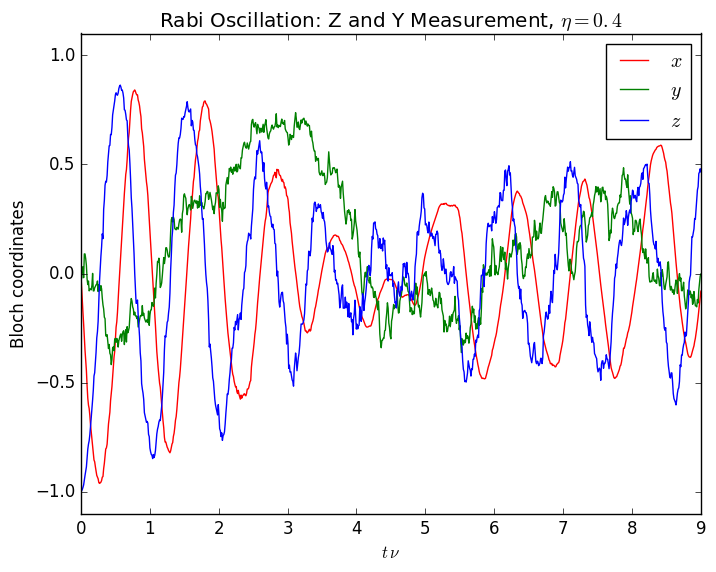

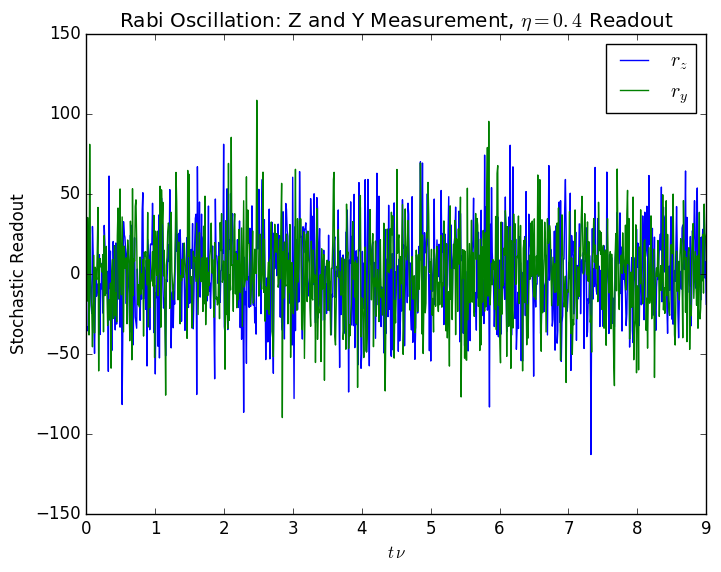

  0.085198 seconds (415.30 k allocations: 32.156 MB, 3.76% gc time)


INFO: Readout: values = 2
INFO: Time elapsed: 0.084249466 s, Steps per second: 10670.690779215147


In [14]:
sol = ensemble_realization(ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.053681581 s, Steps per second: 16746.89871745767
INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.049168546 s, Steps per second: 18284.046878262376


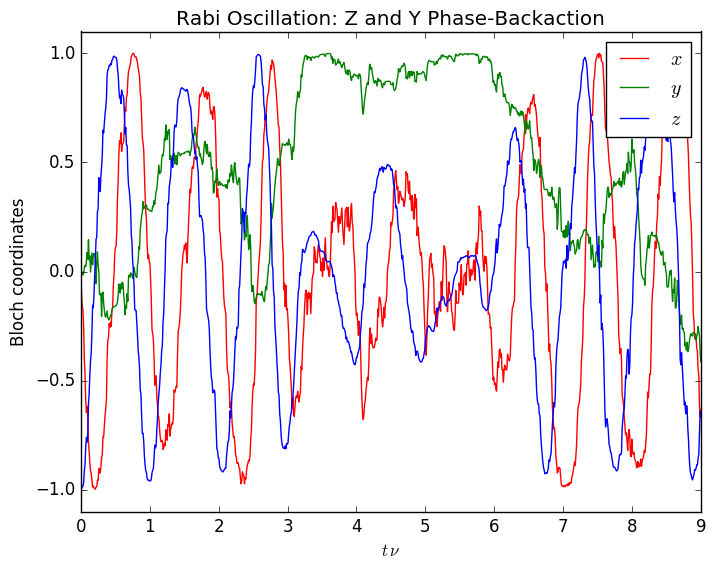

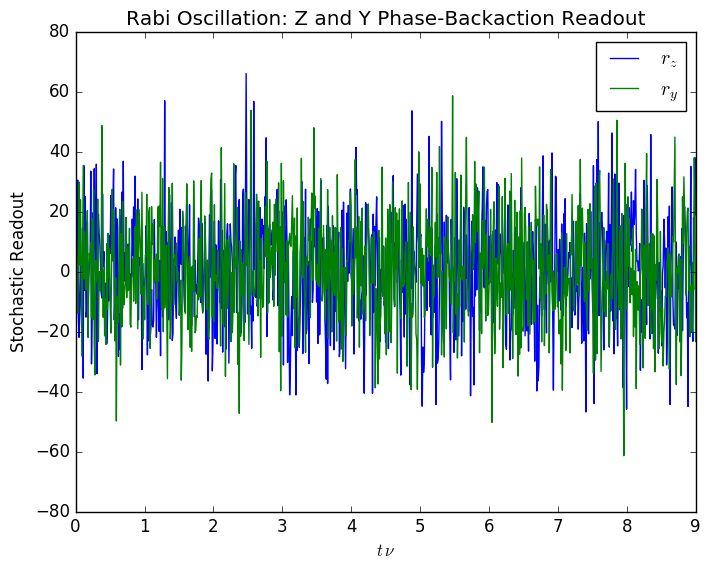

  0.053199 seconds (311.24 k allocations: 22.133 MB, 12.52% gc time)


In [15]:
sol = ensemble_realization(ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.091029826 s, Steps per second: 9875.883976752852
INFO: Trajectory: steps = 899, points = 899, values = 3


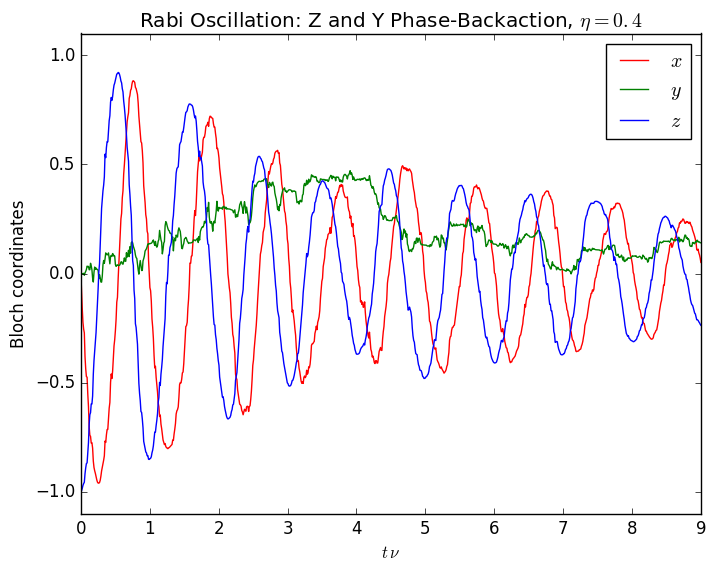

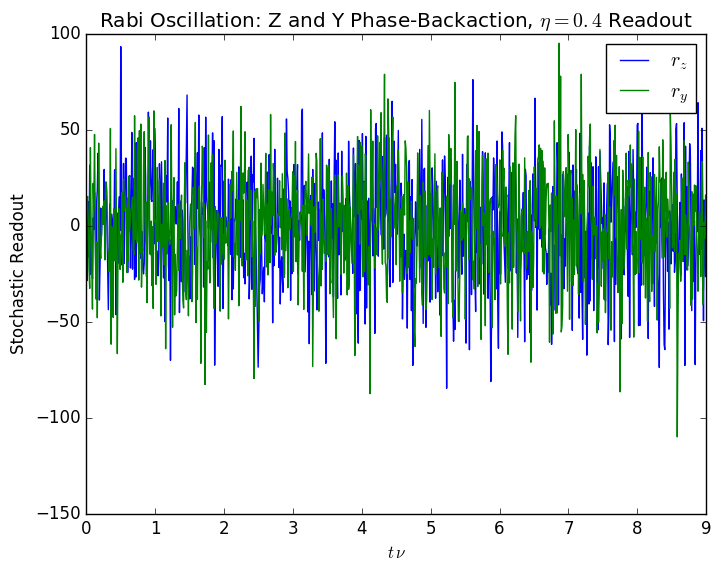

  0.090742 seconds (437.44 k allocations: 31.661 MB, 7.33% gc time)


INFO: Readout: values = 2
INFO: Time elapsed: 0.089743099 s, Steps per second: 10017.483349889666


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [17]:
# Ensemble size, for easy tunability
num = 2000;

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 4.154735271 s, Steps: 1798, Steps per second: 432.7592211590513
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


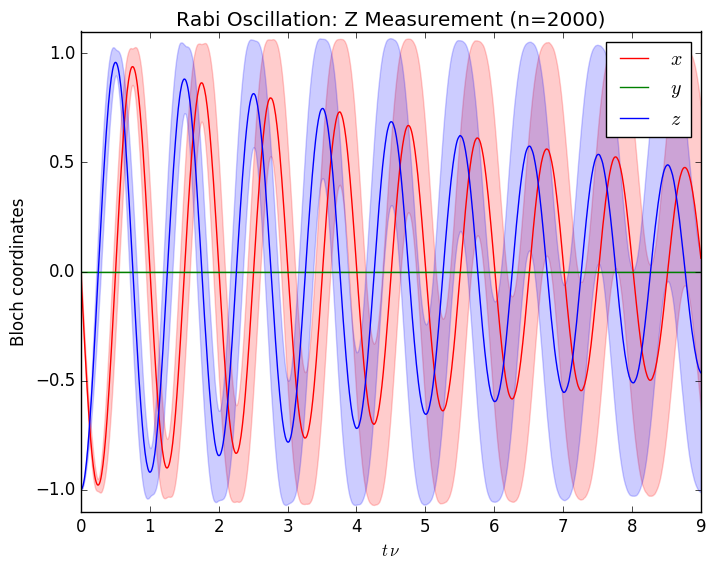

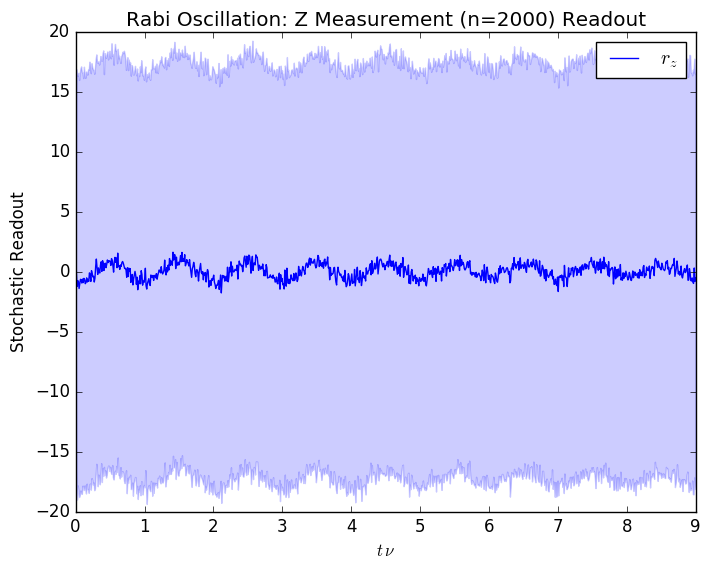

 36.820135 seconds (1.71 M allocations: 156.979 MB, 0.52% gc time)


INFO: Time elapsed: 36.701808301 s, Steps: 1798000, Steps per second: 48989.41178195328


In [18]:
e = ensemble_realization(n=2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.21106153 s, Steps: 1798, Steps per second: 8518.842822754104
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


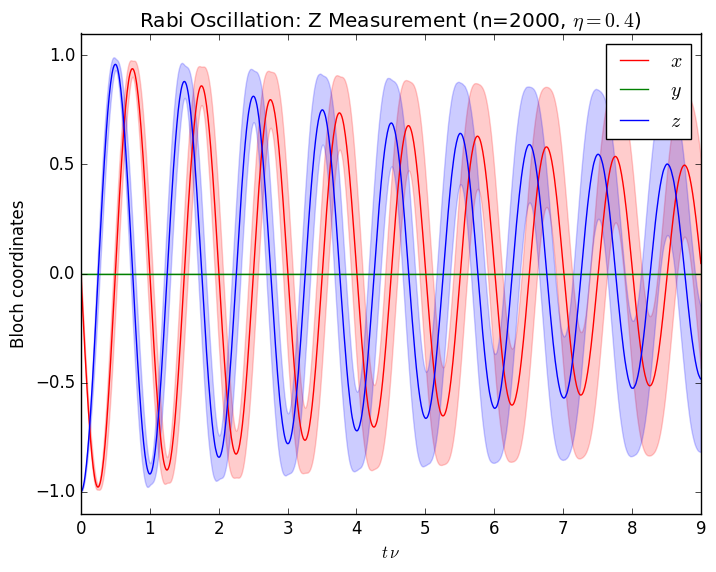

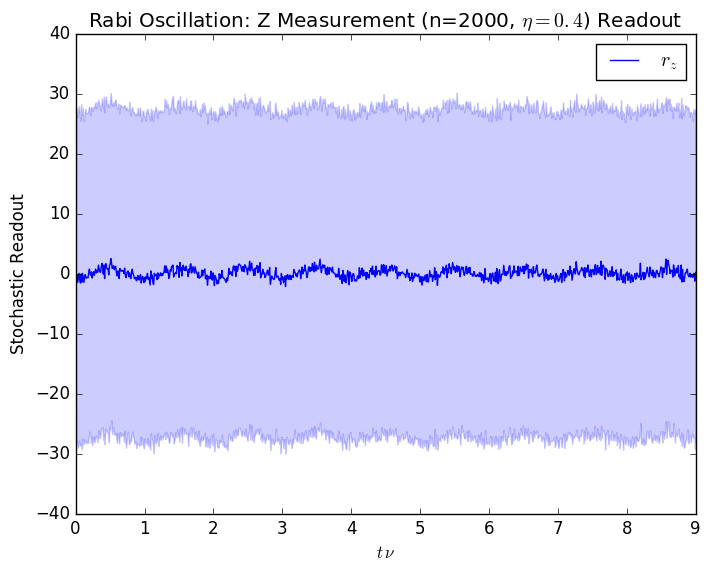

 61.680058 seconds (1.86 M allocations: 154.173 MB, 0.19% gc time)


INFO: Time elapsed: 61.561807742 s, Steps: 1798000, Steps per second: 29206.41979090764


In [19]:
e = ensemble_realization(n=2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.063489 s, Steps: 1798, Steps per second: 28319.866433555417
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


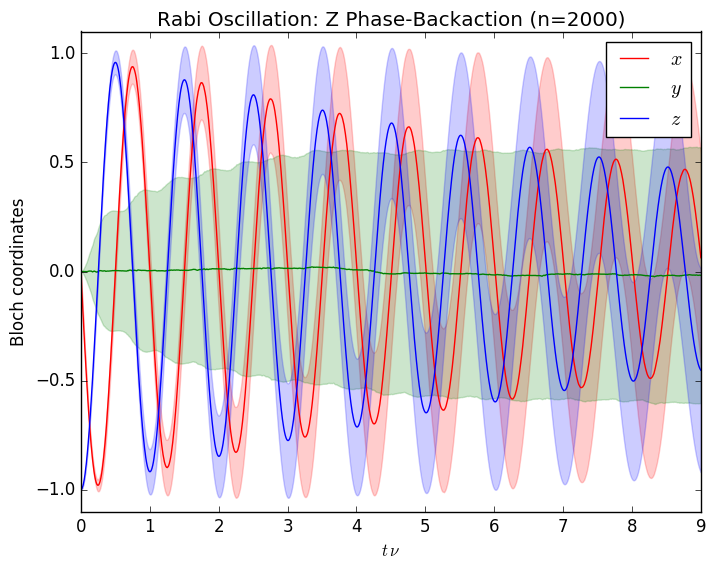

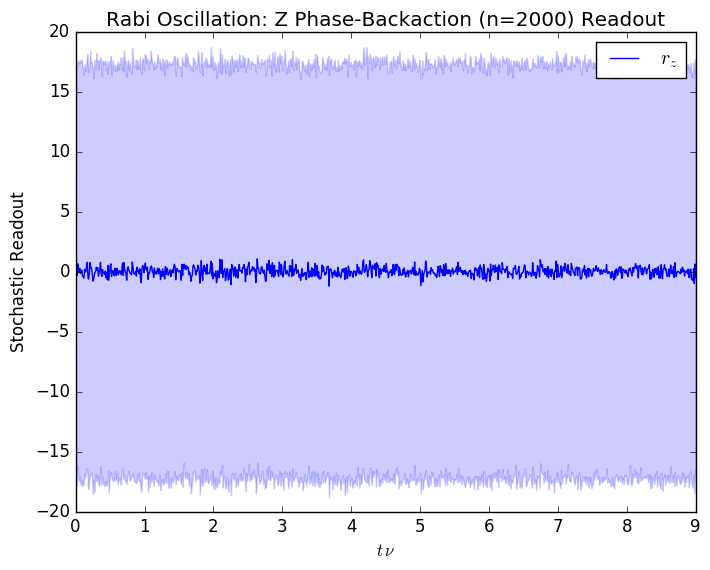

 39.392466 seconds (1.51 M allocations: 147.641 MB, 0.10% gc time)


INFO: Time elapsed: 39.335736774 s, Steps: 1798000, Steps per second: 45709.07138031379


In [20]:
e = ensemble_realization(n=2, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1
INFO: Time elapsed: 0.064116136 s, Steps: 1798, Steps per second: 28042.862720236288
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


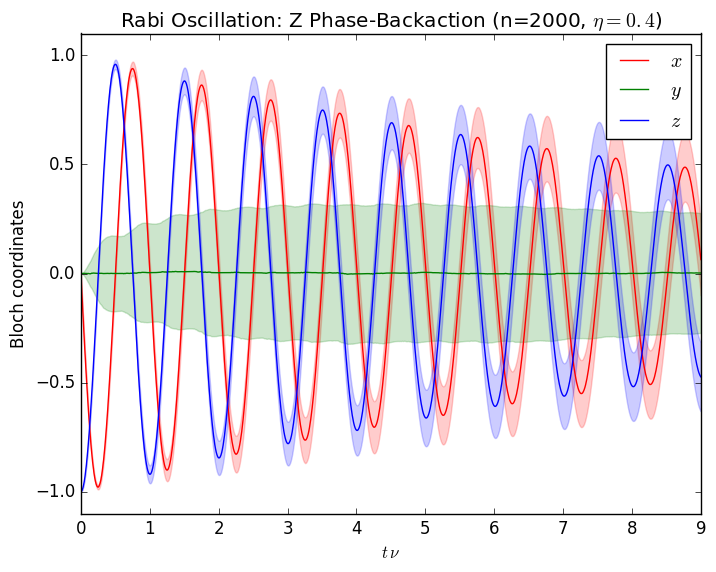

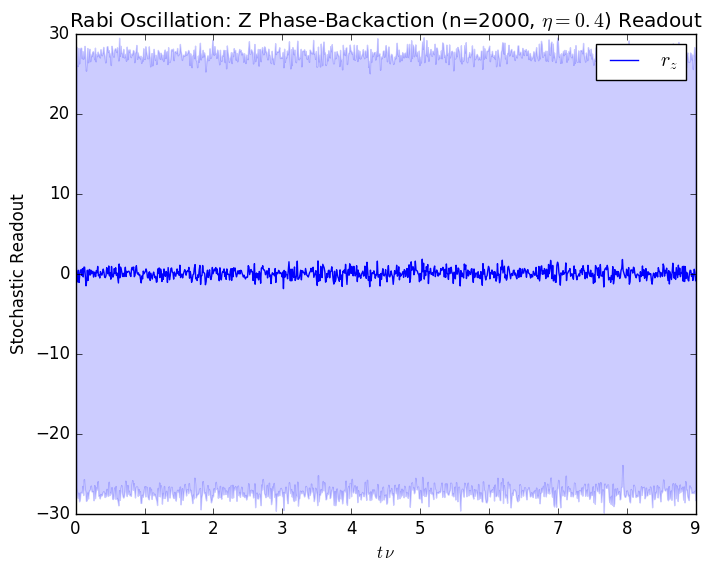

 72.364767 seconds (1.86 M allocations: 154.192 MB, 0.15% gc time)


INFO: Time elapsed: 72.256344692 s, Steps: 1798000, Steps per second: 24883.627972936596


In [21]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.13227603 s, Steps: 1798, Steps per second: 13592.78774846811
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


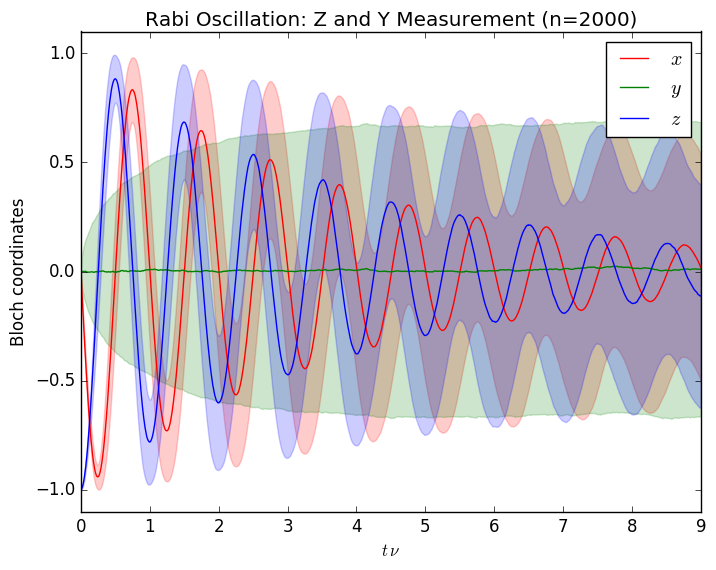

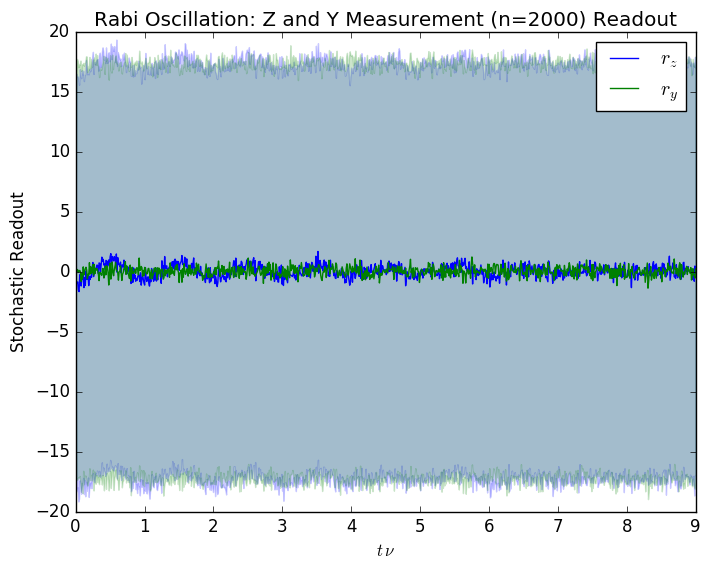

 54.011189 seconds (1.88 M allocations: 182.909 MB, 0.33% gc time)


INFO: Time elapsed: 53.739214948 s, Steps: 1798000, Steps per second: 33457.87618482722


In [22]:
e = ensemble_realization(n=2, ymeas=true) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.205330587 s, Steps: 1798, Steps per second: 8756.610626160631
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


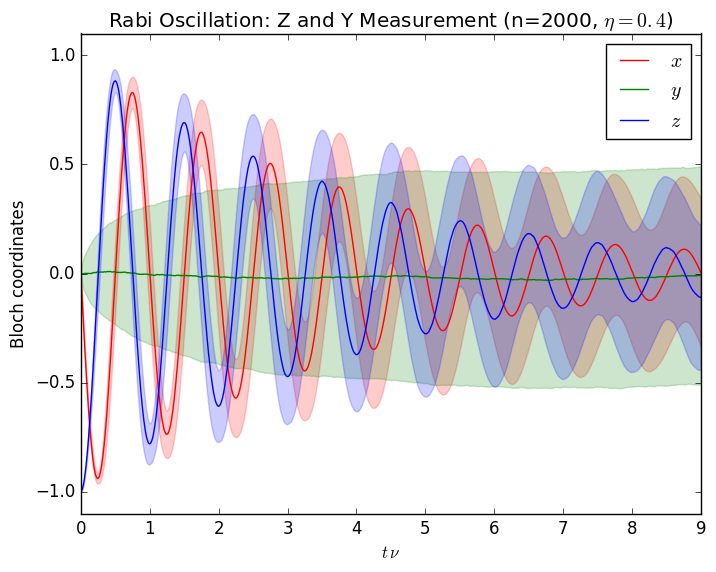

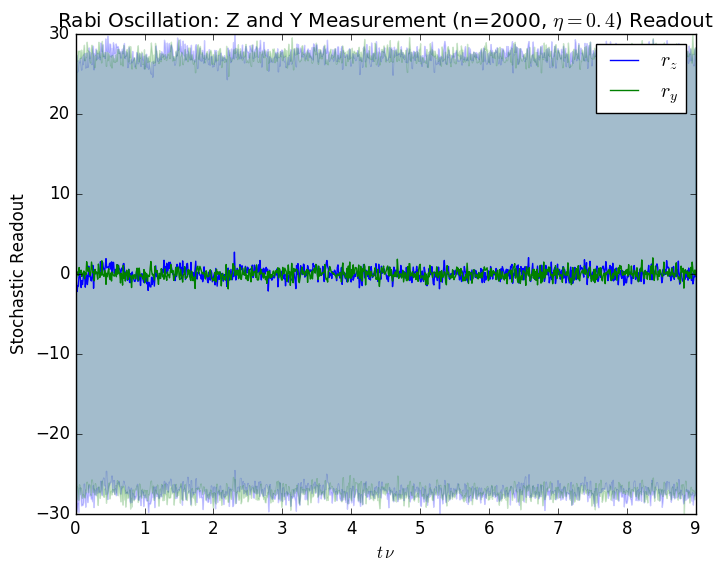

106.168669 seconds (2.37 M allocations: 191.967 MB, 0.11% gc time)


INFO: Time elapsed: 106.034524921 s, Steps: 1798000, Steps per second: 16956.741224988582


In [23]:
e = ensemble_realization(n=2, ymeas=true, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.103026278 s, Steps: 1798, Steps per second: 17451.85825309539
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


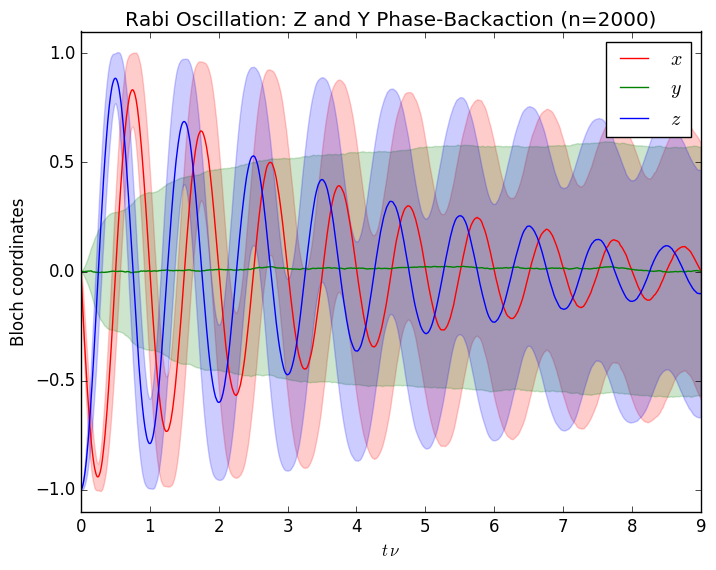

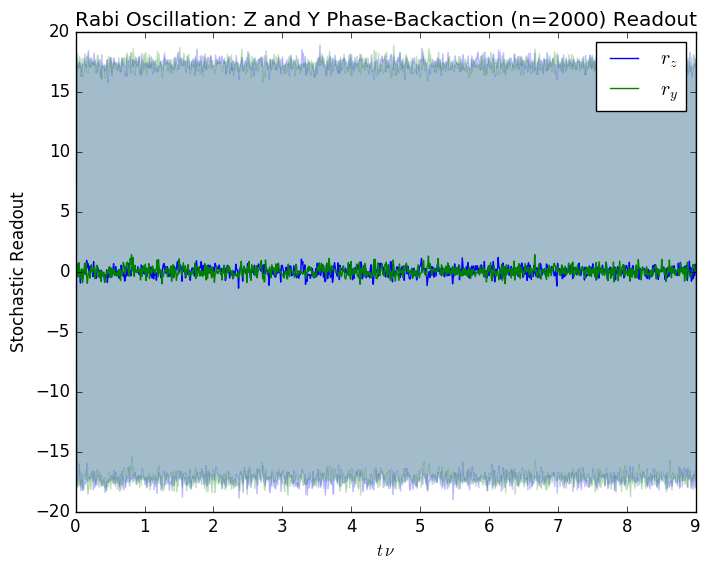

 56.533529 seconds (1.88 M allocations: 182.911 MB, 0.07% gc time)


INFO: Time elapsed: 56.462528098 s, Steps: 1798000, Steps per second: 31844.128496677928


In [24]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

INFO: Trajectories: 2, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2
INFO: Time elapsed: 0.122614868 s, Steps: 1798, Steps per second: 14663.800804320077
INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


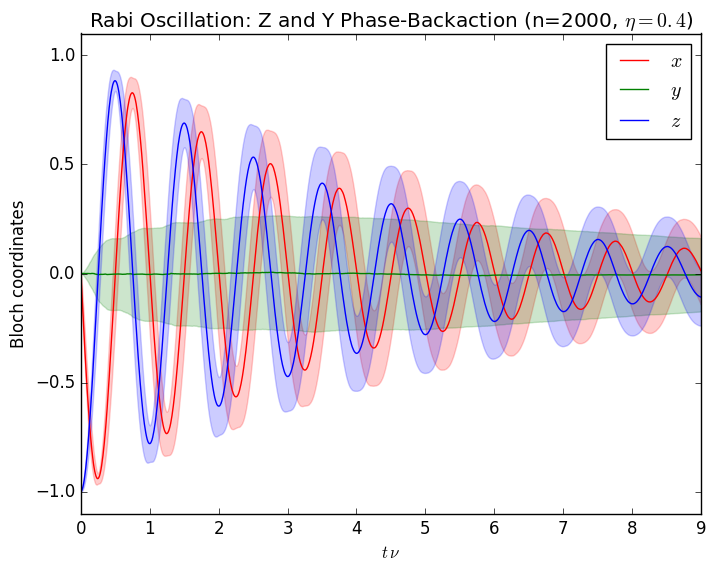

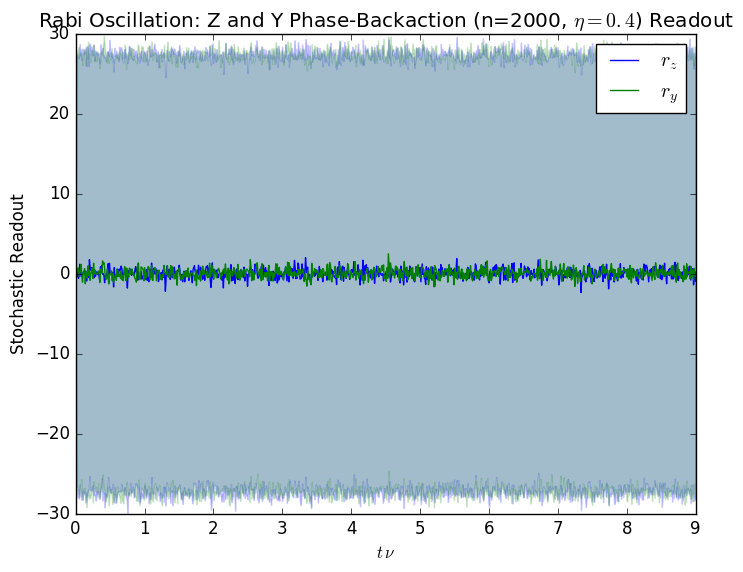

106.999887 seconds (2.37 M allocations: 191.953 MB, 0.10% gc time)


INFO: Time elapsed: 106.87076318 s, Steps: 1798000, Steps per second: 16824.05876499328


In [25]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [26]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6560U CPU @ 2.20GHz
  WORD_SIZE: 64
  BLAS: libopenblas (NO_LAPACKE DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: liblapack.so.3
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, broadwell)


In [27]:
Pkg.installed("PyPlot")

v"2.2.4"

In [28]:
Pkg.installed("QuantumBayesian")

v"0.0.0-"

In [29]:
Pkg.installed("Interpolations")

v"0.3.6"